In [1]:
%load_ext autoreload
%autoreload 2

import typing
from typing import List, Iterable
import pickle
import numpy as np
import pandas as pd

import rdkit

from utils import *

import os, glob


Loaded 97 descriptor functions


In [2]:
import gpflow
from gpflow.mean_functions import Constant
from gpflow.utilities import positive, print_summary
from gpflow.utilities.ops import broadcasting_elementwise
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from rdkit.Chem import AllChem, Descriptors, MolFromSmiles
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

2024-02-13 14:03:53.219487: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 14:03:53.309198: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-13 14:03:53.643763: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-13 14:03:53.645091: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-13 14:03:57.433343: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [28]:
with open("dataset/596/data.pkl", 'rb') as file:
    data = pickle.load(file)

X = np.array(data['fp_ls'])
y = np.array(data['activity_ls'])

In [29]:
X = X[:10000]
y = y[:10000]
X = X.astype(float)
y = y.reshape(-1,1).astype(float)

In [30]:
%%time

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * RBF(1.0)

gp = GaussianProcessClassifier(kernel=kernel,random_state=0)
gp.fit(X, y)

gp.score(X, y)
gp.predict_proba(X[:2,:])

/home/hz454/.conda/envs/chem/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 30min 50s, sys: 2min 24s, total: 33min 14s
Wall time: 33min 16s


array([[0.86090598, 0.13909402],
       [0.86090596, 0.13909404]])

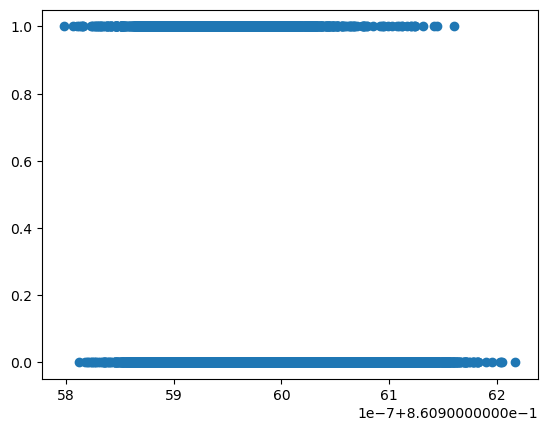

In [31]:
plt.scatter(gp.predict_proba(X[:,:])[:,0], y)

In [15]:
class Tanimoto(gpflow.kernels.Kernel):
    def __init__(self):
        super().__init__()
        # We constrain the value of the kernel variance to be positive when it's being optimised
        self.variance = gpflow.Parameter(1.0, transform=positive())

    def K(self, X, X2=None):
        """
        Compute the Tanimoto kernel matrix σ² * ((<x, y>) / (||x||^2 + ||y||^2 - <x, y>))
        :param X: N x D array
        :param X2: M x D array. If None, compute the N x N kernel matrix for X.
        :return: The kernel matrix of dimension N x M
        """
        if X2 is None:
            X2 = X

        Xs = tf.reduce_sum(tf.square(X), axis=-1)  # Squared L2-norm of X
        X2s = tf.reduce_sum(tf.square(X2), axis=-1)  # Squared L2-norm of X2
        outer_product = tf.tensordot(X, X2, [[-1], [-1]])  # outer product of the matrices X and X2

        # Analogue of denominator in Tanimoto formula

        denominator = -outer_product + broadcasting_elementwise(tf.add, Xs, X2s)

        return self.variance * outer_product/denominator

    def K_diag(self, X):
        """
        Compute the diagonal of the N x N kernel matrix of X
        :param X: N x D array
        :return: N x 1 array
        """
        return tf.fill(tf.shape(X)[:-1], tf.squeeze(self.variance))

In [ ]:
%%time

m = gpflow.models.VGP(
    (X, y),
    likelihood=gpflow.likelihoods.Bernoulli(),
    kernel=Tanimoto(),
)

opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, variables=m.trainable_variables)

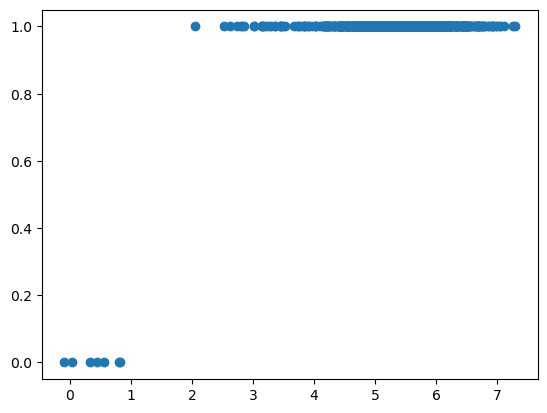

In [27]:
plt.scatter(m.predict_f(X)[0], y)